In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "drive/My Drive/Colab Notebooks/ML_proj2"

/content/drive/My Drive/Colab Notebooks/ML_proj2


In [ ]:
ls

data/  data_augmentation.py  load_helpers.py  __pycache__/


In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from skimage import io

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction import image

#import kerastuner as kt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from data_augmentation import *
from load_helpers import *

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
# Loaded a set of images
root_dir =os.path.join("data", "training")

image_dir = os.path.join(root_dir, "images/")
files = os.listdir(image_dir)
imgs = np.asarray([load_image(image_dir + files[i]) for i in range(len(files))])

gt_dir =  os.path.join(root_dir, "groundtruth/")

gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range( len(files))])

In [ ]:
len(imgs)

100

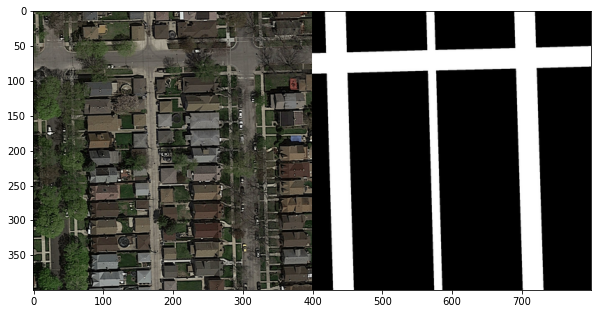

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
index = 6
plt.imshow(concatenate_images(imgs[index], gt_imgs[index]))

In [ ]:
#run it only once !!!!!!!!! 
#if you wanna run again delete  9dom augmented files!!!!!!!

max_iters=30
augment_dataset2(imgs,gt_imgs,image_dir,gt_dir,max_iters)


here 2


In [ ]:
# Loaded a set of images
files_aug = os.listdir(image_dir)
imgs_aug = np.asarray([load_image(image_dir + files_aug[i]) for i in range(len(files_aug))])

files_gt = os.listdir(gt_dir)
gt_imgs_aug = np.asarray([load_image(gt_dir + files_gt[i]) for i in range( len(files_aug))])

In [ ]:
print(np.shape(imgs_aug[0])[0])

400


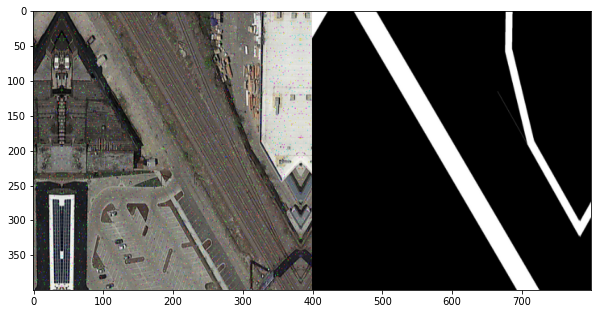

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
index = 148
plt.imshow(concatenate_images(imgs_aug[index], gt_imgs_aug[index]))

In [ ]:
n = len(imgs)

# Extract patches from input images
patch_size = 4 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [ ]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
X = np.asarray([ img_patches[i] for i in range(len(img_patches))])
Y = np.asarray([value_to_class_NN(gt_patches[i],foreground_threshold) for i in range(len(gt_patches))])

In [ ]:
#split train test
test_ratio=0.2
random_state=0
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=test_ratio, random_state=random_state)

In [ ]:

from tensorflow.keras import datasets, layers, models
from keras.layers import LeakyReLU, BatchNormalization
#imlement CNN
INPUT_SHAPE=(X_train.shape[1],X_train.shape[2],X_train.shape[3])
model = models.Sequential()
model.add(keras.layers.Input(shape=INPUT_SHAPE))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2),
                                    strides=(1,1)))
model.add(keras.layers.Conv2D(filters=32,
                           kernel_size=(2,2),
                           strides=(1,1),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters=64,
                           kernel_size=(1,1),
                           strides=(1,1),
                           padding='same',
                        input_shape=INPUT_SHAPE))
model.add(LeakyReLU(alpha=0.3) )
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=256,
                           kernel_size=(2,2),
                           strides=(1,1),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same'))
model.add( keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='softmax'))

model.add(keras.layers.Dense(32,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='softmax'))

model.add(keras.layers.Dense(2,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='sigmoid'))

print(model.summary())
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_21 (Averag (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 3, 3, 32)          416       
_________________________________________________________________
batch_normalization_39 (Batc (None, 3, 3, 32)          128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 2, 2, 64)          2112      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 2, 2, 64)        

In [ ]:
"""
INPUT = keras.layers.Input(shape=INPUT_SHAPE)

pool0=keras.layers.AveragePooling2D(pool_size=(2,2),
                                    strides=(1,1))(INPUT)
                                    
conv1 =keras.layers.Conv2D(filters=128,
                           kernel_size=(5,5),
                           strides=(1,1),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE)(pool0)
pool1 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(conv1)
drop1 = keras.layers.Dropout(0.2)(pool1)

conv2 =  keras.layers.Conv2D(filters=256,
                           kernel_size=(5,5),
                           strides=(2,2),
                           padding='same',
                           activation='relu',
                        input_shape=INPUT_SHAPE)(drop1)   
#conv2.add(LeakyReLU(alpha=0.1) )
pool2 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(conv2)
drop2 = keras.layers.Dropout(0.3)(pool2)


conv3 =  keras.layers.Conv2D(filters=64,
                           kernel_size=(10,10),
                           strides=(2,2),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE)(drop2)  
                        
pool3 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(drop2)
drop3 = keras.layers.Dropout(0.3)(pool3)

flat = keras.layers.Flatten()(drop3)

dense1 = keras.layers.Dense(32,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='softmax')(flat)

dense2 = keras.layers.Dense(2,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='sigmoid')(dense1)

model = keras.Model(inputs=INPUT,outputs=dense2)
print(model.summary())
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
"""

"\nINPUT = keras.layers.Input(shape=INPUT_SHAPE)\n\npool0=keras.layers.AveragePooling2D(pool_size=(2,2),\n                                    strides=(1,1))(INPUT)\n                                    \nconv1 =keras.layers.Conv2D(filters=128,\n                           kernel_size=(5,5),\n                           strides=(1,1),\n                           activation='relu',\n                           padding='same',\n                        input_shape=INPUT_SHAPE)(pool0)\npool1 = keras.layers.MaxPool2D(pool_size=(2,2),\n                               padding='same')(conv1)\ndrop1 = keras.layers.Dropout(0.2)(pool1)\n\nconv2 =  keras.layers.Conv2D(filters=256,\n                           kernel_size=(5,5),\n                           strides=(2,2),\n                           padding='same',\n                           activation='relu',\n                        input_shape=INPUT_SHAPE)(drop1)   \n#conv2.add(LeakyReLU(alpha=0.1) )\npool2 = keras.layers.MaxPool2D(pool_size=(2,2),\n  

In [ ]:
model.fit(X_train, Y_train, epochs=3, batch_size=64)

Epoch 1/3
12500/12500 [==============================] - 91s 7ms/step - loss: 0.6657 - accuracy: 0.7850
Epoch 2/3
12500/12500 [==============================] - 92s 7ms/step - loss: 0.5669 - accuracy: 0.7850
Epoch 3/3
12500/12500 [==============================] - 92s 7ms/step - loss: 0.5669 - accuracy: 0.7850


In [ ]:
test=model.evaluate(X_test,Y_test)

6250/6250 [==============================] - 11s 2ms/step - loss: 0.5707 - accuracy: 0.7820
